## Табличное Q-обучение


Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686">


<!-- Раскроем скобки:
$$Q(s,a)\leftarrow (1 - \alpha) \times Q(s,a)+\alpha \times \big (r(s)+\gamma\max_{a'}Q(a',s')\big ).$$ -->

Для обучения будем использовать среду Taxi-v3. Подробнее про данное окружение можно посмотреть в документации: https://gymnasium.farama.org/environments/toy_text/taxi/.

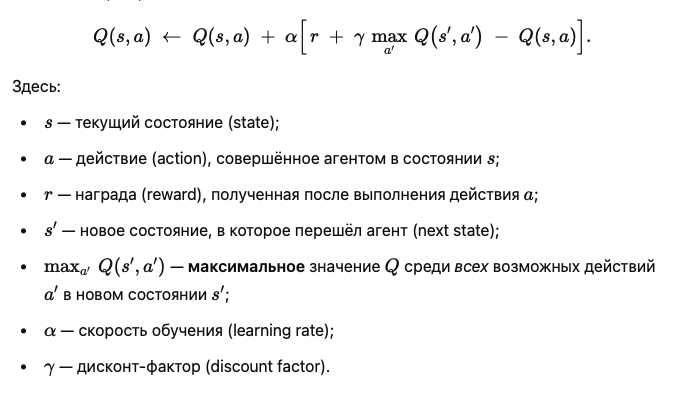

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
# !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
# !pip -q install piglet
# !pip -q install imageio_ffmpeg
# !pip -q install moviepy==1.0.3
# !pip -q install matplotlib

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from gymnasium.wrappers import RecordVideo

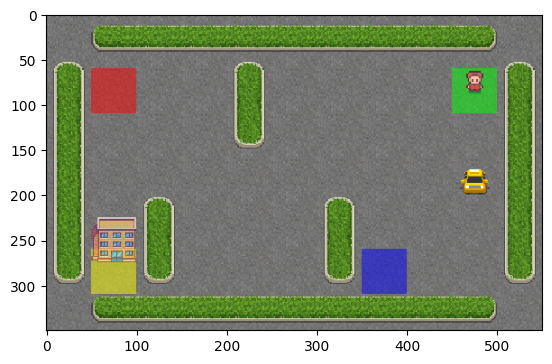

In [4]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
# env = gym.make('FrozenLake-v1', render_mode='rgb_array')

env.reset()
plt.imshow(env.render())
plt.show()

In [5]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

In [6]:
from IPython.display import HTML
from base64 import b64encode
import glob
import os

def show_video(video_path):
    """
    Показывает видео в Jupyter notebook
    """
    # Находим последнее созданное видео в директории
    video_files = glob.glob(os.path.join(video_path, "*.mp4"))
    if not video_files:
        print("No video files found")
        return
    
    latest_video = max(video_files, key=os.path.getctime)
    
    # Читаем видео файл и кодируем его в base64
    with open(latest_video, 'rb') as f:
        video_data = f.read()
    video_base64 = b64encode(video_data).decode()
    
    # Создаем HTML для отображения видео
    video_html = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    
    return HTML(video_html)

### Задание 1

Создайте таблицу из нулей, используя информацию из окружения о количестве состояний и действий

In [7]:
def initialize_q_table(n_observation_space, n_action_space):
    # Q = [state][action]
    """<codehere>"""
    shape = n_observation_space, n_action_space
    Q = np.zeros(shape)
    """</codehere>"""
    return Q

In [8]:
# Пространство состояний:
print(f"Пространство состояний: {env.observation_space.n}")
# Пространство действий:
print(f"Пространство действий: {env.action_space.n}")

Пространство состояний: 500
Пространство действий: 6


In [9]:
print(f"Пример состояния: {env.observation_space.sample()}")
print(f"Пример действия: {env.action_space.sample()}")

Пример состояния: 201
Пример действия: 1


In [10]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

### Задание 2

Напишите код для epsilon-жадного выбора действия:

$$
a = \begin{cases}
\arg\max_a Q(s,a) & \text{с вероятностью } 1-\epsilon \\
\text{случайное действие} & \text{с вероятностью } \epsilon
\end{cases}
$$

In [11]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    # action = 
    """<codehere>"""
    # вероятность (1-eps)
    if epsilon < np.random.random(): # случайное число из Uniform[0,1)
        # используем Q-функцию
        action = np.argmax(Q[state])
    # вероятность eps
    else:
        action = np.random.choice(Q.shape[1])
    """</codehere>"""
    return action

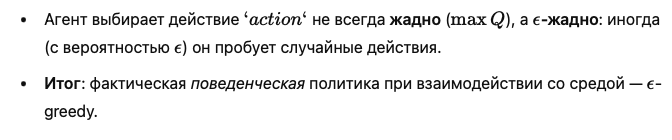

In [12]:
# Проверка функции
select_action_eps_greedy(Q, 2, 0.2)

np.int64(0)

Напишите код для формулы Q-обновления:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \big(r + \gamma \max_{a'} Q(s',a') - Q(s,a)\big)
$$

In [13]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # alpha: learning rate, gamma: discount factor
    # вычисли V(next_s) - estimate of optimal future value
    # V_ns = 
    """<codehere>"""
    V_ns = np.max(Q[next_s])
    """</codehere>"""

    # посчитай TD ошибку
    # td_error = 
    """<codehere>"""
    td_error = r + gamma * V_ns - Q[s, a]
    """</codehere>"""

    # обновление Q-функции
    Q[s, a] += alpha * td_error

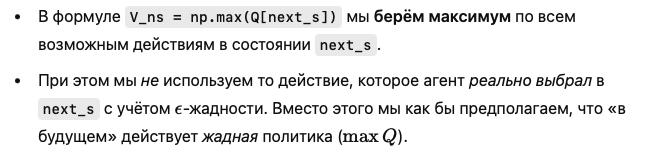

Допишите код итерации Q-обучения:

In [14]:
def q_learning(env, n_episodes=10_000, alpha=0.1, gamma=0.9, epsilon=0.2, epsilon_decay=0.95):
    # определяем память, в которой будет храниться Q(s,a)
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []

    for i_episode in range(1, n_episodes + 1):
        s, _ = env.reset()

        r, episode_reward = 0, 0
        terminated = False

        while not terminated:
            # select action eps-greedy
            # a = ...
            """<codehere>"""
            a = select_action_eps_greedy(Q, s, epsilon)
            """</codehere>"""

            # выполняем действие в среде 
            next_s, r, terminated, truncated, _ = env.step(a)

            # Update Q-function
            """<codehere>"""
            update_Q(Q, s, a, r, next_s, alpha, gamma,)
            """</codehere>"""

            s = next_s
            episode_reward += r

        rewards_batch.append(episode_reward)
        if i_episode % 100 == 0:
            show_progress(rewards_batch, log)
            rewards_batch = []
            print(f"Episode: {i_episode}, Reward: {episode_reward}, Eps: {epsilon}")
            epsilon *= epsilon_decay
            
    # assert log[-1] >= -10
    return Q, log

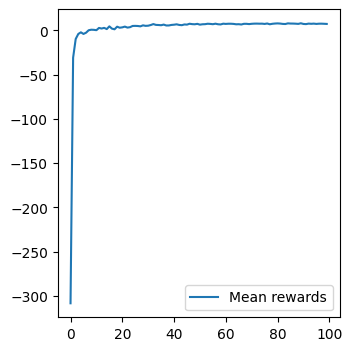

Episode: 10000, Reward: 4, Eps: 0.001246427204280841


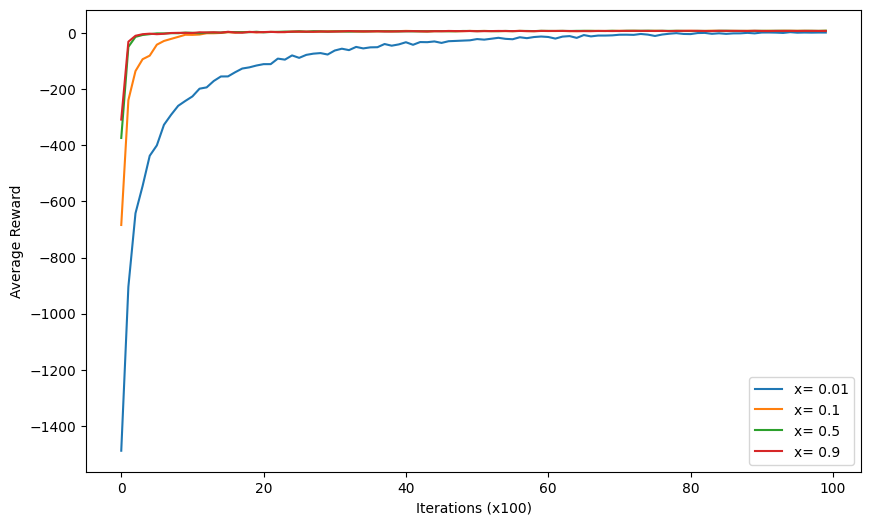

In [15]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

# Пример запуска с разными параметрами
xs = [0.01, 0.1, 0.5, 0.9]
results = {}

for x_ in xs:
    print(f"\nTraining with x = {x_}")
    Q, log = q_learning(env, n_episodes=10000, alpha=x_)
    results[x_] = log

# Визуализация результатов
plt.figure(figsize=(10, 6))
for x_ in xs:
    plt.plot(results[x_], label=f'x= {x_}')
plt.xlabel('Iterations (x100)')
plt.ylabel('Average Reward')
# plt.xscale('log')
plt.legend()
plt.show()

In [17]:
env = gym.make('Taxi-v3', render_mode='rgb_array')
env = RecordVideo(env, "videos/q-learning-taxi-v3/", episode_trigger=lambda x: True)

# Запускаем один эпизод для записи
state, _ = env.reset()
terminated = False

while not terminated:
    action = np.argmax(Q[state])
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    
    if terminated or truncated:
        break

env.close()

# Показываем видео в ноутбуке
show_video("videos/q-learning-taxi-v3/")

/opt/miniconda3/envs/q-learning/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/kurise/Work/AI-Masters/RL/seminar3-q-learninig-sarsa-td-lambda/videos/q-learning-taxi-v3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Интерпретация результатов:
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

## SARSA

Теперь ради интереса попробуем то же самое, но используя метод SARSA.

Для начала, добавим функцию обновления Q-функции:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha\big(r + \gamma Q(s',a') - Q(s,a)\big)
$$

In [18]:
def update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon):
    # выбери следующее действие eps-greedy
    # next_a = 
    """<codehere>"""
    next_a = select_action_eps_greedy(Q, next_s, epsilon)
    """</codehere>"""

    # посчитай TD ошибку
    # td_error = 
    """<codehere>"""
    td_error = r + gamma * Q[next_s, next_a] - Q[s, a]
    """</codehere>"""

    # обновление Q-функции
    Q[s, a] += alpha * td_error

Допишите код итерации SARSA-обучения:

In [19]:
def sarsa(env, n_episodes=10_000, alpha=0.1, gamma=0.9, epsilon=0.2, epsilon_decay=0.95):
    # определяем память, в которой будет храниться Q(s,a)
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []

    for episode in range(1, n_episodes + 1):
        s, _ = env.reset()

        r, episode_reward = 0, 0
        terminated = False

        while not terminated:
            # select action eps-greedy
            # a = ...
            """<codehere>"""
            a = select_action_eps_greedy(Q, s, epsilon)
            """</codehere>"""

            # выполняем действие в среде 
            next_s, r, terminated, truncated, info = env.step(a)

            # Update Q-function with SARSA
            """<codehere>"""
            update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon)
            """</codehere>"""

            s = next_s
            episode_reward += r

        rewards_batch.append(episode_reward)
        if episode % 100 == 0:
            
            show_progress(rewards_batch, log)
            rewards_batch = []
            print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
            epsilon *= epsilon_decay
            
    # assert log[-1] >= -10
    return Q, log

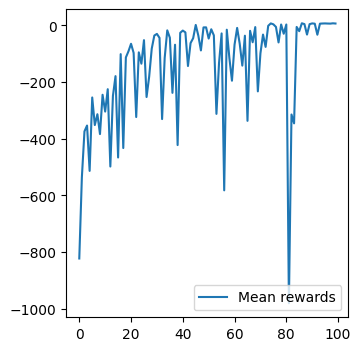

Episode: 10000, Reward: 9, Eps: 0.001246427204280841


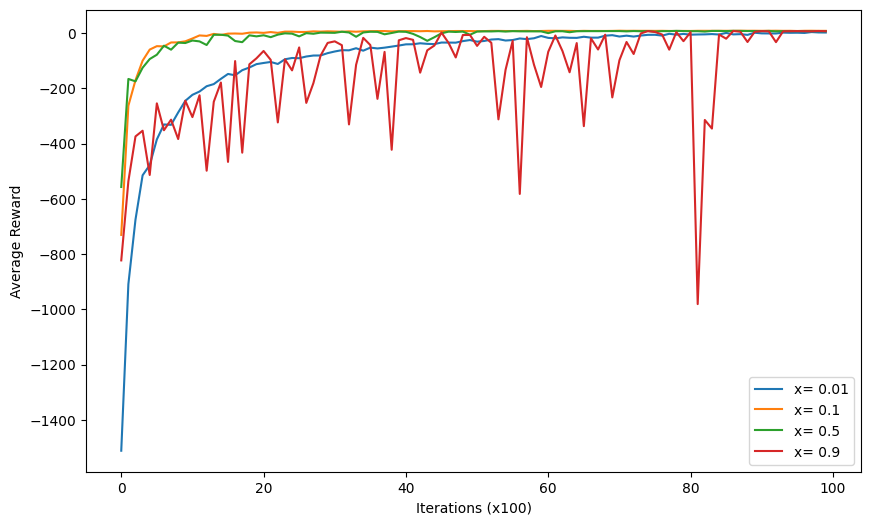

In [20]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

# Пример запуска с разными параметрами
xs = [0.01, 0.1, 0.5, 0.9]
results = {}

for x_ in xs:
    print(f"\nTraining with x = {x_}")
    Q, log = sarsa(env, n_episodes=10000, alpha=x_)
    results[x_] = log

# Визуализация результатов
plt.figure(figsize=(10, 6))
for x_ in xs:
    plt.plot(results[x_], label=f'x= {x_}')
plt.xlabel('Iterations (x100)')
plt.ylabel('Average Reward')
# plt.xscale('log')
plt.legend()
plt.show()

In [23]:
env = gym.make('Taxi-v3', render_mode='rgb_array')
env = RecordVideo(env, "videos/sarsa-taxi-v3/", episode_trigger=lambda x: True)

state, _ = env.reset()
terminated = False

while not terminated:
    action = np.argmax(Q[state])
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    
    if terminated or truncated:
        break

env.close()

show_video("videos/sarsa-taxi-v3/")

Сравнивая SARSA и Q-learning, что можно сказать об их кривых обучения? (быстрее-медленнее, обучение стабильнее или нет и тп)

In [24]:
# """<comment>"""
# from codehere import convert
# import os

# os.makedirs('render', exist_ok=True)

# nb_name = 'q-learning-sarsa'
# convert(
#     file=f'{nb_name}.ipynb',
#     outfile=f'render/{nb_name}.ipynb',
#     clear=True, replacement=" Здесь ваш код "
# )
# convert(
#     file=f'{nb_name}.ipynb',
#     outfile=f'render/{nb_name}-solution.ipynb',
#     clear=True, solution=True, replacement=" Здесь ваш код "
# )
# """</comment>"""

Таким образом, нет абсолютного ответа, какой алгоритм «лучше» всегда. Выбор зависит от задачи, среды и того, как именно мы собираем опыт. Однако Q-learning часто упоминают как один из наиболее популярных методов, поскольку он «прямо целится» в оптимальную политику (что удобно, когда мы можем позволить себе достаточно случайного исследования и большие данные). SARSA же предпочитают в ситуациях, где важно придерживаться согласованного с обучением поведения и где «рисковые» действия действительно желательно избегать в процессе обучения.

# TD-lambda

## TD(λ)

TD(λ) - это обобщение методов временных различий, которое использует следы приемлемости (eligibility traces) для более эффективного обучения. Метод объединяет преимущества TD-обучения и Monte Carlo методов.

Формула обновления для TD(λ):

Q(s,a) ← Q(s,a) + α × δ × e(s,a)

где:
- δ - TD-ошибка
- e(s,a) - след приемлемости для пары состояние-действие
- λ - параметр, определяющий скорость затухания следов (0 ≤ λ ≤ 1)

Следы приемлемости обновляются по формуле:
e(s,a) ← γλe(s,a) + 1(если посетили (s,a))

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \delta_t e_t(s,a)
$$

$$
e_t(s,a) \leftarrow \gamma\lambda e_{t-1}(s,a) + \mathbf{1}_{(s_t,a_t)=(s,a)}
$$

Temporal Difference:

**Q-learning:**

$$
\delta_t = r_t + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t)
$$

**SARSA:**

$$
\delta_t = r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)
$$

**TD($\lambda$):**

$$
\delta_t = \sum_{n=1}^{\infty} (\gamma\lambda)^{n-1}[r_t + \gamma V_{t+n} - V_t]
$$

In [25]:
import numpy as np

def initialize_eligibility_traces(n_states, n_actions):
    """Инициализация следов приемлемости"""
    return np.zeros((n_states, n_actions))

def update_eligibility_traces(e, s, a, gamma, lambda_):
    """Обновление следов приемлемости"""
    e *= gamma * lambda_
    e[s, a] += 1
    return e

def update_Q_TD_lambda(Q, e, td_error, alpha):
    """Обновление Q-значений с использованием TD(λ)"""
    Q += alpha * td_error * e

### Задание 3

Реализуйте алгоритм SARSA(λ):

In [26]:
def sarsa_lambda(env, n_episodes, alpha=0.1, gamma=0.9, lambda_=0.9, epsilon=0.1):
    # Инициализация Q-таблицы и логов
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []
    
    for episode in range(1, n_episodes + 1):
        # Инициализация следов приемлемости
        e = initialize_eligibility_traces(env.observation_space.n, env.action_space.n)
        s, _ = env.reset()
        
        # Выбор начального действия
        a = select_action_eps_greedy(Q, s, epsilon)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            # Выполнение действия
            next_s, r, terminated, truncated, _ = env.step(a)
            
            # Выбор следующего действия
            next_a = select_action_eps_greedy(Q, next_s, epsilon)
            
            # Вычисление TD-ошибки
            td_error = r + gamma * Q[next_s, next_a] * (not terminated) - Q[s, a]
            
            # Обновление следов приемлемости
            e = update_eligibility_traces(e, s, a, gamma, lambda_)
            
            # Обновление Q-значений
            update_Q_TD_lambda(Q, e, td_error, alpha)
            
            s, a = next_s, next_a
            episode_reward += r
            
        rewards_batch.append(episode_reward)
        if episode % 100 == 0:
            show_progress(rewards_batch, log)
            rewards_batch = []
            print(f"Episode: {episode}, Reward: {episode_reward}")
    
    return Q, log

### Задание 4

Сравните работу SARSA(λ) с предыдущими алгоритмами:

1. Запустите SARSA(λ) с разными значениями λ (например, 0, 0.5, 0.9)
2. Постройте графики обучения для разных λ
3. Проанализируйте результаты

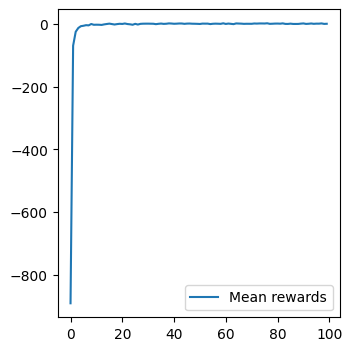

Episode: 10000, Reward: -2


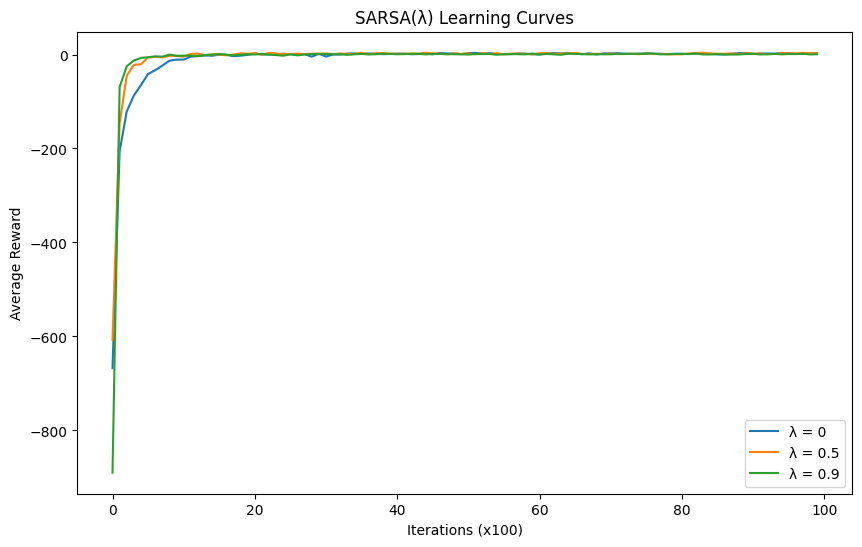

In [26]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

# Пример запуска с разными λ
lambdas = [0, 0.5, 0.9]
results = {}

for lambda_ in lambdas:
    print(f"\nTraining with λ = {lambda_}")
    Q, log = sarsa_lambda(env, n_episodes=10000, lambda_=lambda_)
    results[lambda_] = log

# Визуализация результатов
plt.figure(figsize=(10, 6))
for lambda_ in lambdas:
    plt.plot(results[lambda_], label=f'λ = {lambda_}')
plt.xlabel('Iterations (x100)')
plt.ylabel('Average Reward')
plt.title('SARSA(λ) Learning Curves')
plt.legend()
plt.show()

In [27]:
env = gym.make('Taxi-v3', render_mode='rgb_array')
env = RecordVideo(env, "videos/td-lambda-taxi-v3/", episode_trigger=lambda x: True)

state, _ = env.reset()
terminated = False

while not terminated:
    action = np.argmax(Q[state])
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    
    if terminated or truncated:
        break

env.close()

show_video("videos/td-lambda-taxi-v3/")

/opt/miniconda3/envs/q-learning/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/kurise/Work/AI-Masters/RL/seminar3-q-learninig-sarsa-td-lambda/videos/td-lambda-taxi-v3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Обсуждение

TD(λ) представляет собой компромисс между TD(0) и Monte Carlo методами:
- При λ = 0 метод эквивалентен обычному TD-обучению
- При λ = 1 метод приближается к Monte Carlo
- Промежуточные значения λ позволяют балансировать между:
  - Скоростью обучения
  - Устойчивостью к шуму
  - Эффективностью использования опыта

Преимущества TD(λ):
1. Более эффективное использование информации об обучении
2. Часто быстрее сходится, чем TD(0)
3. Помогает решить проблему присваивания кредита (credit assignment problem)

Недостатки:
1. Требует больше вычислительных ресурсов
2. Более сложная настройка гиперпараметров

### Дополнительное задание

Попробуйте реализовать Q(λ) - версию Q-learning с использованием следов приемлемости. 
Основное отличие от SARSA(λ) заключается в том, как вычисляется TD-ошибка:
- В Q(λ) используется максимальное Q-значение для следующего состояния
- Требуется аккуратное обращение со следами приемлемости при "off-policy" обучении

In [36]:
### TD(λ) - общий принцип

def td_lambda_update(Q, e, s, a, r, next_s, next_a, terminated, alpha, gamma, lambda_, method='sarsa'):
    """
    Обновление Q-значений используя TD(λ)
    
    Параметры:
    - method: 'sarsa' или 'q_learning' - метод вычисления TD-ошибки
    """
    if method == 'sarsa':
        # SARSA: используем выбранное следующее действие
        td_target = r + gamma * Q[next_s, next_a] * (not terminated)
    elif method == 'q_learning':
        # Q-learning: используем максимальное значение следующего состояния
        td_target = r + gamma * np.max(Q[next_s]) * (not terminated)
    else:
        raise ValueError("Method must be either 'sarsa' or 'q_learning'")
    
    # Вычисляем TD-ошибку
    td_error = td_target - Q[s, a]
    
    # Обновляем Q-значения используя следы приемлемости
    Q += alpha * td_error * e

def td_lambda(env, n_episodes, method='sarsa', alpha=0.1, gamma=0.9, lambda_=0.9, epsilon=0.1):
    """
    Реализация TD(λ) с поддержкой как SARSA, так и Q-learning
    """
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []
    
    for episode in range(1, n_episodes + 1):
        # Инициализация следов приемлемости
        e = initialize_eligibility_traces(env.observation_space.n, env.action_space.n)
        s, _ = env.reset()
        a = select_action_eps_greedy(Q, s, epsilon)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            # Выполнение действия
            next_s, r, terminated, truncated, _ = env.step(a)
            
            # Выбор следующего действия
            next_a = select_action_eps_greedy(Q, next_s, epsilon)
            
            # Обновление следов приемлемости
            e = update_eligibility_traces(e, s, a, gamma, lambda_)
            
            # TD(λ) обновление
            td_lambda_update(Q, e, s, a, r, next_s, next_a, terminated, 
                           alpha, gamma, lambda_, method=method)
            
            # Если используем Q-learning и выбранное действие не является жадным,
            # обнуляем следы приемлемости (важно для off-policy алгоритмов)
            if method == 'q_learning' and next_a != np.argmax(Q[next_s]):
                e *= 0
            
            s, a = next_s, next_a
            episode_reward += r
            
        rewards_batch.append(episode_reward)
        if episode % 100 == 0:
            show_progress(rewards_batch, log)
            rewards_batch = []
            print(f"Episode: {episode}, Method: {method}, λ={lambda_}, "
                  f"Reward: {episode_reward}")
    
    return Q, log

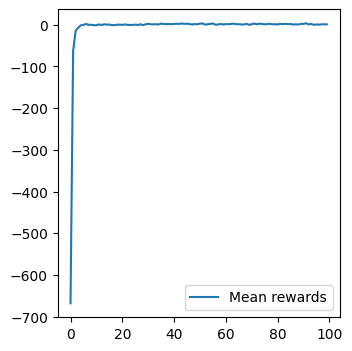

Episode: 10000, Method: q_learning, λ=0.9, Reward: -1


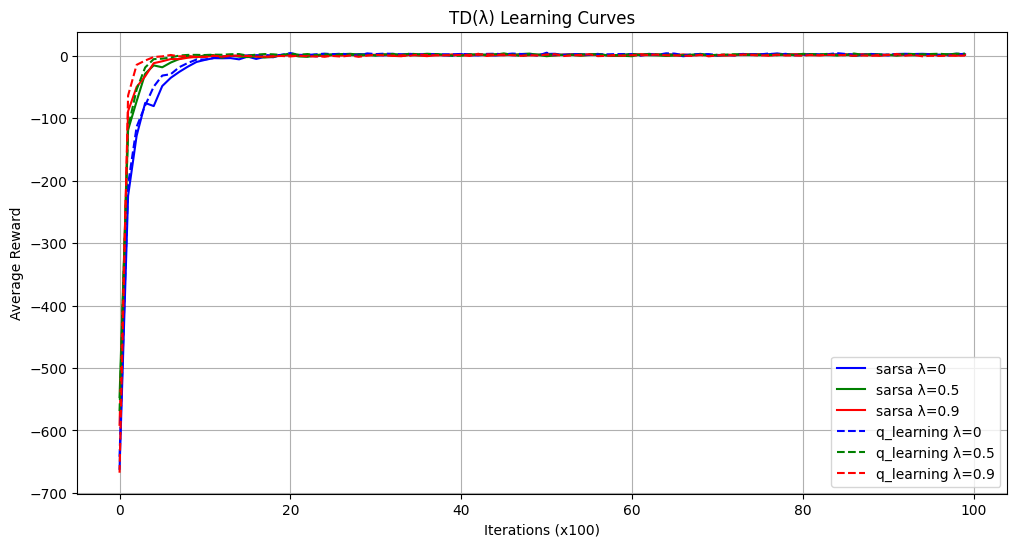

In [39]:
env = gym.make('Taxi-v3', render_mode='rgb_array')

# Сравнение разных вариантов TD(λ)
methods = ['sarsa', 'q_learning']
lambdas = [0, 0.5, 0.9]
results = {}

# Сначала соберем все результаты
for method in methods:
    for lambda_ in lambdas:
        print(f"\nTraining with method={method}, λ={lambda_}")
        Q, log = td_lambda(env, n_episodes=10000, method=method, lambda_=lambda_)
        results[f"{method}_lambda{lambda_}"] = log

# Затем построим все графики на одном полотне
plt.figure(figsize=(12, 6))
colors = ['b', 'g', 'r']  # разные цвета для разных значений lambda
linestyles = ['-', '--']  # разные стили линий для разных методов

for i, method in enumerate(methods):
    for j, lambda_ in enumerate(lambdas):
        key = f"{method}_lambda{lambda_}"
        plt.plot(results[key], 
                label=f'{method} λ={lambda_}',
                color=colors[j],
                linestyle=linestyles[i])

plt.xlabel('Iterations (x100)')
plt.ylabel('Average Reward')
plt.title('TD(λ) Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

### Анализ результатов

Теперь мы можем сравнить:
1. Влияние λ на скорость обучения и стабильность
2. Различия между SARSA(λ) и Q(λ)
3. Компромисс между on-policy (SARSA) и off-policy (Q-learning) методами

Основные наблюдения:
1. При λ=0 оба метода работают как их базовые версии (SARSA и Q-learning)
2. При увеличении λ:
   - Увеличивается скорость начального обучения
   - Может увеличиться вариативность обучения
   - Усиливается влияние долгосрочных последствий
3. Q(λ) может быть менее стабильным из-за off-policy природы алгоритма

### Практическое задание

1. Исследуйте влияние различных комбинаций гиперпараметров:
   - λ и α (learning rate)
   - λ и γ (discount factor)
   - λ и ε (exploration rate)

2. Сравните производительность алгоритмов на разных средах:
   - Попробуйте более простые среды (например, FrozenLake)
   - Попробуйте более сложные среды (например, CartPole с дискретизацией)

3. Реализуйте вариант с затухающим λ:
   - Начните с большого λ для быстрого начального обучения
   - Постепенно уменьшайте λ для большей стабильности

In [66]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Создаем среду
env = gym.make('CartPole-v1')

def discretize_state(state):
    """Дискретизация непрерывного состояния"""
    # Определяем границы для каждой компоненты состояния
    bounds = [
        [-2.4, 2.4],  # cart position
        [-2.0, 2.0],  # cart velocity
        [-0.418, 0.418],  # pole angle
        [-2.0, 2.0]  # pole angular velocity
    ]
    
    # Количество бинов для каждой компоненты
    n_bins = [10, 10, 50, 10]
    
    digitized = []
    for i, (s, (lower, upper), bins) in enumerate(zip(state, bounds, n_bins)):
        # Масштабируем значение в диапазон [0, n_bins-1]
        scaled = np.interp(s, [lower, upper], [0, bins-1])
        digitized.append(int(np.clip(scaled, 0, bins-1)))
    
    # Преобразуем список индексов в одно число
    return np.ravel_multi_index(digitized, n_bins)

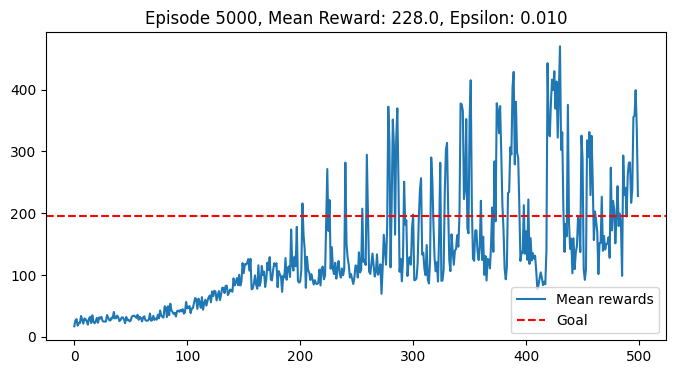

In [71]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Инициализация Q-таблицы
n_states = 10 * 10 * 50 * 10  # Общее количество дискретных состояний
n_actions = env.action_space.n
Q = np.zeros((n_states, n_actions))

# Гиперпараметры
alpha = 0.1
gamma = 0.99
epsilon = 0.9
epsilon_min = 0.01
epsilon_decay = 0.999
n_episodes = 5000

# Логирование
log = []
rewards_batch = []

for episode in range(1, n_episodes + 1):
    state, _ = env.reset()
    state = discretize_state(state)
    episode_reward = 0
    terminated = False
    
    while not terminated:
        # Выбор действия с помощью epsilon-greedy
        if np.random.random() > epsilon:
            action = np.argmax(Q[state])
        else:
            action = env.action_space.sample()
            
        # Выполняем действие
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state)
        
        # Обновляем Q-значение
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state, best_next_action] * (not terminated)
        td_error = td_target - Q[state, action]
        Q[state, action] += alpha * td_error
        
        state = next_state
        episode_reward += reward
        
        if terminated or truncated:
            break
    
    # Уменьшаем epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Логирование
    rewards_batch.append(episode_reward)
    if episode % 10 == 0:
        mean_reward = np.mean(rewards_batch)
        log.append(mean_reward)
        rewards_batch = []
        
        clear_output(True)
        plt.figure(figsize=[8, 4])
        plt.plot(log, label='Mean rewards')
        plt.axhline(y=195, color='r', linestyle='--', label='Goal')
        plt.legend(loc=4)
        plt.title(f'Episode {episode}, Mean Reward: {mean_reward:.1f}, Epsilon: {epsilon:.3f}')
        plt.show()

env.close()

In [72]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = RecordVideo(env, "videos/cartpole-v1/", episode_trigger=lambda x: True)

# Запускаем один эпизод для записи
state, _ = env.reset()
state = discretize_state(state)
terminated = False

while not terminated:
    action = np.argmax(Q[state]*np.random.random(n_actions))
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = discretize_state(next_state)
    state = next_state
    
    if terminated or truncated:
        break

env.close()

# Показываем видео в ноутбуке
show_video("videos/cartpole-v1/")